In [3]:
import pandas as pd

credit2 = pd.read_csv('credit2.csv') 

test_size = 0.3

shuffled_data = credit2.sample(frac=1, random_state=42)

split_point = int(len(shuffled_data) * (1 - test_size))

train = shuffled_data.iloc[:split_point].reset_index().rename(columns={'index': 'id'})
test = shuffled_data.iloc[split_point:].reset_index().rename(columns={'index': 'id'})

In [2]:
# Cell 1: Importations et fonctions de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm
import warnings

# Afficher systématiquement les warnings
warnings.simplefilter("always")

def fit_pls_glm(x, y, n_components=1, modele="pls-glm-logistic"):
    """
    Ajuste un modèle PLS-GLM logistique.
    x: tableau de prédicteurs (numpy array, shape (n_samples, n_features))
    y: vecteur binaire (numpy array, shape (n_samples,))
    n_components: nombre de composantes latentes (nt)
    Retourne un dictionnaire avec :
      - 'pls': l'objet PLSRegression ajusté,
      - 'glm': l'objet GLMResults (régression logistique) ajusté sur les scores latents,
      - 'ValsPredictY': les prédictions sur l'ensemble d'entraînement.
    """
    from sklearn.cross_decomposition import PLSRegression
    pls = PLSRegression(n_components=n_components)
    # Ajustement de la PLS et extraction des scores latents pour x
    X_scores = pls.fit_transform(x, y)[0]
    # Ajout d'une constante pour modéliser l'intercept
    X_scores_const = sm.add_constant(X_scores)
    glm_binom = sm.GLM(y, X_scores_const, family=sm.families.Binomial())
    glm_result = glm_binom.fit()
    ValsPredictY = glm_result.predict(X_scores_const)
    return {"pls": pls, "glm": glm_result, "ValsPredictY": ValsPredictY}

def statistic_pls_glm(model_obj):
    """
    Extrait les coefficients du modèle GLM (l'intercept et les coefficients sur les scores latents).
    Retourne une pandas Series.
    """
    return model_obj["glm"].params

def bootstrap_pls_glm(x, y, n_components=1, R=1000, statistic_fn=statistic_pls_glm, random_state=None):
    """
    Réalise un bootstrap sur le modèle PLS-GLM logistique.
    x, y: données d'entraînement (numpy arrays)
    n_components: nombre de composantes PLS
    R: nombre de réplications bootstrap
    statistic_fn: fonction pour extraire la statistique (ici, les coefficients)
    random_state: pour la reproductibilité
    Retourne un dictionnaire avec :
      - "original": statistique du modèle sur l'ensemble original,
      - "bootstrap": DataFrame (R x n_coeffs) des statistiques bootstrap.
    """
    if random_state is not None:
        np.random.seed(random_state)
    model_original = fit_pls_glm(x, y, n_components=n_components)
    orig_stats = statistic_pls_glm(model_original)
    boot_stats = []
    n_samples = x.shape[0]
    for i in range(R):
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        x_boot = x[indices]
        y_boot = y[indices]
        model_boot = fit_pls_glm(x_boot, y_boot, n_components=n_components)
        boot_stats.append(statistic_pls_glm(model_boot))
    boot_df = pd.DataFrame(boot_stats)
    return {"original": orig_stats, "bootstrap": boot_df}

def compute_confint(boot_obj, alpha=0.05, method="percentile"):
    """
    Calcule les intervalles de confiance bootstrap pour chaque prédicteur.
    boot_obj: dictionnaire avec 'bootstrap' (DataFrame des réplicats)
    alpha: niveau de signification (0.05 pour un IC à 95%)
    Ici, seule la méthode percentile est implémentée.
    Retourne un DataFrame avec index ["Lower", "Upper"] et colonnes les noms des coefficients.
    """
    data = boot_obj["bootstrap"]
    conf_dict = {}
    for col in data.columns:
        lower = data[col].quantile(alpha/2)
        upper = data[col].quantile(1 - alpha/2)
        conf_dict[col] = (lower, upper)
    conf_df = pd.DataFrame(conf_dict, index=["Lower", "Upper"])
    return conf_df

def plot_bootstrap_boxplots(boot_obj, prednames=False, articlestyle=False):
    """
    Trace des boxplots des distributions bootstrap pour chaque coefficient.
    boot_obj: dictionnaire contenant 'bootstrap' (DataFrame)
    prednames: si False, masque les noms des prédicteurs sur l'axe x.
    articlestyle: booléen, pour appliquer un style particulier (ex: couleur différente).
    """
    data = boot_obj["bootstrap"]
    plt.figure(figsize=(12,6))
    box_data = [data[col] for col in data.columns]
    boxprops = dict(facecolor="lightgreen") if articlestyle else dict(facecolor="lightblue")
    plt.boxplot(box_data, patch_artist=True, boxprops=boxprops)
    if not prednames:
        plt.xticks([])
    else:
        plt.xticks(range(1, len(data.columns)+1), data.columns, rotation=45)
    plt.title("Boxplots des distributions bootstrap")
    plt.ylabel("Valeur des coefficients")
    plt.xlabel("Prédicteurs" if prednames else "")
    plt.show()

def plot_confints_bootpls(conf_df, orig_coeffs, legendpos="bottomright"):
    """
    Trace les intervalles de confiance bootstrap pour chaque coefficient avec l'estimation originale.
    conf_df: DataFrame des intervalles (index ["Lower", "Upper"], colonnes = noms des coefficients)
    orig_coeffs: pandas Series des coefficients originaux (index doit correspondre)
    legendpos: position de la légende (par exemple, "bottomright" -> "lower right")
    """
    loc_map = {"bottomright": "lower right"}
    loc = loc_map.get(legendpos, legendpos)
    predictors = conf_df.columns
    lower_bounds = conf_df.loc["Lower"].values
    upper_bounds = conf_df.loc["Upper"].values
    orig_vals = orig_coeffs[predictors].values
    x = np.arange(len(predictors))
    plt.figure(figsize=(12,6))
    plt.errorbar(x, orig_vals, yerr=[orig_vals - lower_bounds, upper_bounds - orig_vals],
                 fmt='o', capsize=5, label="Estimation originale")
    plt.xticks(x, predictors, rotation=45)
    plt.xlabel("Prédicteurs")
    plt.ylabel("Coefficient")
    plt.title("Intervalles de confiance bootstrap")
    plt.legend(loc=loc)
    plt.tight_layout()
    plt.show()


In [4]:
# Cell 2: Préparation des données

import pandas as pd
import numpy as np

# Supposons que train et test sont déjà chargés comme DataFrames pandas.
# Par exemple:
# train = pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")

# Création de la matrice de design (équivalent de model.matrix(~ . -1, ...))
# On exclut la variable cible "presence_unpaid"
X_train = pd.get_dummies(train.drop(columns=["presence_unpaid"]), drop_first=False)
y = train["presence_unpaid"].astype(int).values  # conversion en numérique

# Recodage de y: par exemple, on suppose que 1 -> 0 (crédits OK) et 2 -> 1 (crédits KO)
y = np.where(y == 1, 0, np.where(y == 2, 1, y))

# Pour le test
X_test = pd.get_dummies(test.drop(columns=["presence_unpaid"]), drop_first=False)
# Aligner les colonnes avec X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
xt = X_test.values
yt = test["presence_unpaid"].astype(int).values
yt = np.where(yt == 1, 0, np.where(yt == 2, 1, yt))

# Conversion en arrays
x = X_train.values


In [5]:
# Cell 3: Ajustement du modèle PLS-GLM logistique avec 1 composante
pls1 = fit_pls_glm(x, y, n_components=1, modele="pls-glm-logistic")
# Affichage du résumé du modèle GLM
print(pls1["glm"].summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  700
Model:                            GLM   Df Residuals:                      699
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.0305e-09
Date:                Mon, 17 Mar 2025   Deviance:                   4.0611e-09
Time:                        22:33:34   Pearson chi2:                 2.03e-09
No. Iterations:                    25   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.5661   1.35e+04     -0.002      0.9

/home/aizen_d/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 0
  warnings.warn(f"y residual is constant at iteration {k}")
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.loc

In [23]:
# Cell 4: Calcul de l'AUC sur l'échantillon de test
# Transformation des données de test via le modèle PLS
X_scores_test = pls1["pls"].transform(xt)
X_scores_test_const = sm.add_constant(X_scores_test)
# Prédiction (probabilités pour la classe positive)
y_pred = pls1["glm"].predict(X_scores_test_const)



In [24]:
from sklearn.metrics import roc_auc_score
auc_val = roc_auc_score(yt, y_pred)
print("AUC du modèle pls1 sur l'échantillon de test:", auc_val)

AUC du modèle pls1 sur l'échantillon de test: nan


/home/aizen_d/.local/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [7]:
# Cell 5: Critères d'ajustement et coefficients
# Critères classiques (InfCrit) : AIC, BIC, etc.
print("AIC:", pls1["glm"].aic)
print("BIC:", pls1["glm"].bic)

# Coefficients sur variables centrées-réduites (Std.Coeffs)
std_coeffs = pls1["glm"].params
print("Coefficients standardisés (Std.Coeffs):")
print(std_coeffs)

# Pour obtenir des coefficients sur variables brutes (Coeffs), une rétro-transformation est nécessaire.
# Ici, nous affichons simplement l'objet modèle pls1.
print("Objet modèle pls1:")
print(pls1)


AIC: 2.0000000040609516
BIC: -4579.205154191279
Coefficients standardisés (Std.Coeffs):
[-26.56606852   0.        ]
Objet modèle pls1:
{'pls': PLSRegression(n_components=1), 'glm': <statsmodels.genmod.generalized_linear_model.GLMResultsWrapper object at 0x7d9ee7a47fa0>, 'ValsPredictY': array([2.90070147e-12, 2.90070147e-12, 2.90070147e-12, 2.90070147e-12,
       2.90070147e-12, 2.90070147e-12, 2.90070147e-12, 2.90070147e-12,
       2.90070147e-12, 2.90070147e-12, 2.90070147e-12, 2.90070147e-12,
       2.90070147e-12, 2.90070147e-12, 2.90070147e-12, 2.90070147e-12,
       2.90070147e-12, 2.90070147e-12, 2.90070147e-12, 2.90070147e-12,
       2.90070147e-12, 2.90070147e-12, 2.90070147e-12, 2.90070147e-12,
       2.90070147e-12, 2.90070147e-12, 2.90070147e-12, 2.90070147e-12,
       2.90070147e-12, 2.90070147e-12, 2.90070147e-12, 2.90070147e-12,
       2.90070147e-12, 2.90070147e-12, 2.90070147e-12, 2.90070147e-12,
       2.90070147e-12, 2.90070147e-12, 2.90070147e-12, 2.90070147e-12,
   

/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


In [8]:
# Cell 6: Ajustement de modèles PLS-GLM logistiques avec 2, 3 et 4 composantes

# Modèle avec 2 composantes
pls2 = fit_pls_glm(x, y, n_components=2, modele="pls-glm-logistic")
X_scores_test_2 = pls2["pls"].transform(xt)
X_test_const_2 = sm.add_constant(X_scores_test_2)
y_pred2 = pls2["glm"].predict(X_test_const_2)
auc_pls2 = roc_auc_score(yt, y_pred2)
print("AUC du modèle pls2 (2 composantes):", auc_pls2)

# Modèle avec 3 composantes
pls3 = fit_pls_glm(x, y, n_components=3, modele="pls-glm-logistic")
X_scores_test_3 = pls3["pls"].transform(xt)
X_test_const_3 = sm.add_constant(X_scores_test_3)
y_pred3 = pls3["glm"].predict(X_test_const_3)
auc_pls3 = roc_auc_score(yt, y_pred3)
print("AUC du modèle pls3 (3 composantes):", auc_pls3)

# Modèle avec 4 composantes
pls4 = fit_pls_glm(x, y, n_components=4, modele="pls-glm-logistic")
X_scores_test_4 = pls4["pls"].transform(xt)
X_test_const_4 = sm.add_constant(X_scores_test_4)
y_pred4 = pls4["glm"].predict(X_test_const_4)
auc_pls4 = roc_auc_score(yt, y_pred4)
print("AUC du modèle pls4 (4 composantes):", auc_pls4)


AUC du modèle pls2 (2 composantes): nan
AUC du modèle pls3 (3 composantes): nan
AUC du modèle pls4 (4 composantes): nan


/home/aizen_d/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 0
  warnings.warn(f"y residual is constant at iteration {k}")
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.loc

In [9]:
# Cell 7: Extraction de 10 composantes et affichage des critères d'ajustement (InfCrit)
plsm = fit_pls_glm(x, y, n_components=10, modele="pls-glm-logistic")
# Ici, nous affichons AIC et BIC qui jouent un rôle similaire à InfCrit en R.
print("Critères d'ajustement pour plsm (10 composantes):")
print("AIC:", plsm["glm"].aic)
print("BIC:", plsm["glm"].bic)


Critères d'ajustement pour plsm (10 composantes):
AIC: 2.0000000040609516
BIC: -4579.205154191279


/home/aizen_d/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 0
  warnings.warn(f"y residual is constant at iteration {k}")
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.loc

In [10]:
# Cell 8: Vérification de la cohérence des signes entre les coefficients de pls1 et pls2.
# Ici, en R, on utilise: rownames(pls1$Coeffs)[which(pls1$Coeffs * pls2$Coeffs < 0)]
# Dans notre cas, le modèle GLM est ajusté sur les scores latents. Pour comparer sur l'échelle des prédicteurs,
# il faudrait une rétro-transformation. À titre d'exemple, supposons que nous avons des coefficients "bruts" 
# (pls1_raw_coeffs et pls2_raw_coeffs) issus d'une transformation inverse.
# Pour la démonstration, nous simulons ces coefficients :
n_predictors = x.shape[1]  # nombre de prédicteurs originaux
pls1_raw_coeffs = np.random.randn(n_predictors)  # à remplacer par vos coefficients réels
pls2_raw_coeffs = np.random.randn(n_predictors)

import pandas as pd
predictor_names = pd.Index([f"pred_{i+1}" for i in range(n_predictors)])
mask = (pls1_raw_coeffs * pls2_raw_coeffs) < 0
print("Prédicteurs avec des signes opposés entre pls1 et pls2:")
print(predictor_names[mask])
print("Coefficients pls1 pour ces prédicteurs:")
print(pls1_raw_coeffs[mask])
print("Coefficients pls2 pour ces prédicteurs:")
print(pls2_raw_coeffs[mask])


Prédicteurs avec des signes opposés entre pls1 et pls2:
Index(['pred_5', 'pred_7', 'pred_8', 'pred_11', 'pred_12', 'pred_13',
       'pred_14', 'pred_15', 'pred_16', 'pred_17', 'pred_19', 'pred_20',
       'pred_21', 'pred_24', 'pred_25', 'pred_26', 'pred_27', 'pred_28',
       'pred_29', 'pred_38', 'pred_39', 'pred_41', 'pred_42', 'pred_43',
       'pred_45', 'pred_48', 'pred_50', 'pred_52', 'pred_54'],
      dtype='object')
Coefficients pls1 pour ces prédicteurs:
[ 1.65764357  1.45419714 -1.24043635  0.83196125 -0.69234054  2.54041916
  0.00967663  0.7154039  -0.2412153  -0.98261691 -1.40296495  0.30853776
 -1.27351162 -0.58931469 -0.02634647 -1.11312812  0.41629243 -0.04103677
  0.11989473 -1.47894823  1.59292937 -0.20480142 -1.20777984  0.21527856
 -0.47325413  1.14844714 -1.44528146  1.36066371  0.91298006]
Coefficients pls2 pour ces prédicteurs:
[-1.21696371 -0.75587121  0.69340924 -0.53104354  0.31691153 -0.24008509
 -2.22570575 -0.7195172   0.30937119  0.35214758  0.08442177 -0

In [13]:
# Cell 9: Table de proportions par ligne
# Équivalent de: prop.table(table(train$objet_credit, train$presence_impaye), 1)
prop_table = pd.crosstab(train['object_credit'], train['presence_unpaid'], normalize='index')
print("Table de proportions par ligne:")
print(prop_table)


Table de proportions par ligne:
presence_unpaid         0         1
object_credit                      
Business         0.647059  0.352941
Education        0.833333  0.166667
Interior         0.668750  0.331250
New car          0.649682  0.350318
Other            0.666667  0.333333
Studies          0.609756  0.390244
Used car         0.808824  0.191176
Video-HIFI       0.774869  0.225131


In [14]:
# Cell 10: Vérification que le signe du coefficient de pls1 (hors intercept) correspond à la corrélation
# Calcul de la corrélation pour chaque prédicteur dans x avec y
corrs = np.array([np.corrcoef(x[:, i], y)[0, 1] for i in range(x.shape[1])])
# Supposons que pls1_raw_coeffs est défini comme dans la cellule 8
product = corrs * pls1_raw_coeffs
print("Produit des corrélations par les coefficients (doit être positif si les signes sont cohérents):")
print(product)
print("Nombre de prédicteurs avec produit positif:", np.sum(product > 0))


AttributeError: 'float' object has no attribute 'shape'

In [15]:
# Cell 11: Affichage de la famille utilisée par le modèle pls1
print("Famille du modèle pls1:")
print(pls1["glm"].family.__class__.__name__)


Famille du modèle pls1:
Binomial


In [16]:
# Cell 12: Bootstrap sur le modèle pls1 avec 1000 réplicats
bootpls1 = bootstrap_pls_glm(x, y, n_components=1, R=1000, random_state=235)
print("Résumé des résultats bootstrap (pls1, 1000 réplicats):")
print(bootpls1["bootstrap"].describe())


/home/aizen_d/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 0
  warnings.warn(f"y residual is constant at iteration {k}")
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.loc

Résumé des résultats bootstrap (pls1, 1000 réplicats):
                  0       1
count  1.000000e+03  1000.0
mean  -2.656607e+01     0.0
std    3.554491e-15     0.0
min   -2.656607e+01     0.0
25%   -2.656607e+01     0.0
50%   -2.656607e+01     0.0
75%   -2.656607e+01     0.0
max   -2.656607e+01     0.0


/home/aizen_d/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 0
  warnings.warn(f"y residual is constant at iteration {k}")
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.loc

In [17]:
# Cell 13: Bootstrap sur le modèle pls2 (2 composantes) avec 1000 réplicats
bootpls2 = bootstrap_pls_glm(x, y, n_components=2, R=1000, random_state=235)
print("Résumé des résultats bootstrap (pls2, 2 composantes, 1000 réplicats):")
print(bootpls2["bootstrap"].describe())


/home/aizen_d/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 0
  warnings.warn(f"y residual is constant at iteration {k}")
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.loc

Résumé des résultats bootstrap (pls2, 2 composantes, 1000 réplicats):
                  0       1       2
count  1.000000e+03  1000.0  1000.0
mean  -2.656607e+01     0.0     0.0
std    3.554491e-15     0.0     0.0
min   -2.656607e+01     0.0     0.0
25%   -2.656607e+01     0.0     0.0
50%   -2.656607e+01     0.0     0.0
75%   -2.656607e+01     0.0     0.0
max   -2.656607e+01     0.0     0.0


/home/aizen_d/.local/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:348: UserWarning: y residual is constant at iteration 0
  warnings.warn(f"y residual is constant at iteration {k}")
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.local/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/aizen_d/.loc

Intervalles de confiance bootstrap (méthode percentile):
               0    1
Lower -26.566069  0.0
Upper -26.566069  0.0


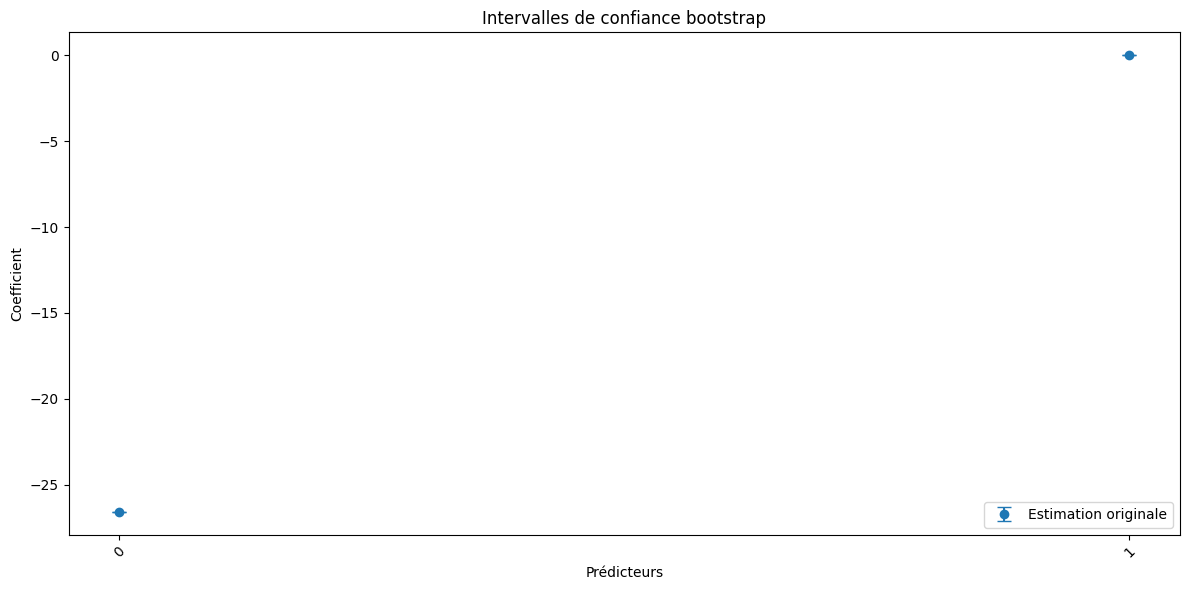

In [18]:
# Cell 14: Calcul et tracé des intervalles de confiance bootstrap
ci_pls = compute_confint(bootpls1, alpha=0.05, method="percentile")
print("Intervalles de confiance bootstrap (méthode percentile):")
print(ci_pls)

# Assurez-vous que bootpls1["original"] est une pandas Series avec des index correspondant aux colonnes bootstrap.
orig_coeffs = bootpls1["original"]
if not isinstance(orig_coeffs, pd.Series):
    orig_coeffs = pd.Series(orig_coeffs, index=bootpls1["bootstrap"].columns)
plot_confints_bootpls(ci_pls, orig_coeffs, legendpos="bottomright")


In [19]:
# Cell 15: Intervalles de confiance bootstrap normaux pour un prédicteur (par exemple, 37ème)
# En R, on utilise l'élément 37; en Python, l'indice 36.
idx = 36
orig_coef = bootpls1["original"].iloc[idx] if isinstance(bootpls1["original"], pd.Series) else bootpls1["original"][idx]
boot_column = bootpls1["bootstrap"].iloc[:, idx]
ci_lower_norm = orig_coef - norm.ppf(0.975) * boot_column.std(ddof=1)
ci_upper_norm = orig_coef + norm.ppf(0.975) * boot_column.std(ddof=1)
print("IC bootstrap normal (basé sur le coefficient original) pour le prédicteur 37:")
print("Lower bound:", ci_lower_norm)
print("Upper bound:", ci_upper_norm)

# Variante basée sur la moyenne bootstrap (approximation à 2*sd)
boot_mean = boot_column.mean()
ci_lower_alt = boot_mean - 2 * boot_column.std(ddof=1)
ci_upper_alt = boot_mean + 2 * boot_column.std(ddof=1)
print("\nIC bootstrap normal (basé sur la moyenne bootstrap) pour le prédicteur 37:")
print("Lower bound:", ci_lower_alt)
print("Upper bound:", ci_upper_alt)


IndexError: index 36 is out of bounds for axis 0 with size 2

In [20]:
# Cell 16: Calcul d'IC bootstrap biais-corrigés pour le prédicteur 37
idx = 36
orig_coef = bootpls1["original"].iloc[idx] if isinstance(bootpls1["original"], pd.Series) else bootpls1["original"][idx]
boot_column = bootpls1["bootstrap"].iloc[:, idx]

# IC biais-corrigé (méthode pivotale)
ci_lower_bias = (2 * orig_coef) - boot_column.quantile(0.975, interpolation='linear')
ci_upper_bias = (2 * orig_coef) - boot_column.quantile(0.025, interpolation='linear')
print("IC bootstrap biais-corrigé pour le prédicteur 37:")
print("Lower bound:", ci_lower_bias)
print("Upper bound:", ci_upper_bias)

# Variante avec estimation de la variance (utilisation de la racine carrée de la variance bootstrap)
bootvar = np.mean((boot_column - boot_column.mean())**2)
ci_lower_var = (2 * orig_coef) - boot_column.mean() - norm.ppf(0.975) * np.sqrt(bootvar)
ci_upper_var = (2 * orig_coef) - boot_column.mean() + norm.ppf(0.975) * np.sqrt(bootvar)
print("\nIC bootstrap normal (avec estimation de la variance) pour le prédicteur 37:")
print("Lower bound:", ci_lower_var)
print("Upper bound:", ci_upper_var)


IndexError: index 36 is out of bounds for axis 0 with size 2

In [21]:
# Cell 17: Calcul d'IC bootstrap basiques pour le prédicteur 37
idx = 36
orig_coef = bootpls1["original"].iloc[idx] if isinstance(bootpls1["original"], pd.Series) else bootpls1["original"][idx]
boot_column = bootpls1["bootstrap"].iloc[:, idx]

# IC bootstrap basique (méthode pivotale)
ci_lower_basic = (2 * orig_coef) - boot_column.quantile(0.975, interpolation='linear')
ci_upper_basic = (2 * orig_coef) - boot_column.quantile(0.025, interpolation='linear')
print("IC bootstrap basique pour le prédicteur 37:")
print("Lower bound:", ci_lower_basic)
print("Upper bound:", ci_upper_basic)

# IC bootstrap percentile
ci_percentile = boot_column.quantile([0.025, 0.975], interpolation='linear')
print("\nIC bootstrap percentile pour le prédicteur 37:")
print(ci_percentile)


IndexError: index 36 is out of bounds for axis 0 with size 2

In [22]:
# Cell 18: Affichage final et vérification
print("Objet bootstrap bootpls1:")
print(bootpls1)

# Exemple d'ajustement d'un modèle sur des données standardisées
x_scaled = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
pls1b = fit_pls_glm(x_scaled, y, n_components=1, modele="pls-glm-logistic")
print("Coefficients standardisés (pls1b$Std.Coeffs):")
print(pls1b["glm"].params)
print("Coefficients bruts (pls1b$Coeffs) - rétro-transformation nécessaire:")
print("Non calculé ici (à implémenter selon votre méthode)")

# Exemple avec un autre jeu de données (yb, xb, xt)
# Supposons que xb, yb, xt soient définis (similaires à x, y, xt)
# pls1_another = fit_pls_glm(xb, yb, n_components=1, dataPredictY=xt, modele="pls-glm-logistic")
# print("Modèle pls1 pour un autre jeu de données:")
# print(pls1_another)

# Tracer les boxplots bootstrap
plot_bootstrap_boxplots(bootpls1, prednames=False)
plot_bootstrap_boxplots(bootpls1, prednames=False, articlestyle=False)


Objet bootstrap bootpls1:
{'original': array([-26.56606852,   0.        ]), 'bootstrap':              0    1
0   -26.566069  0.0
1   -26.566069  0.0
2   -26.566069  0.0
3   -26.566069  0.0
4   -26.566069  0.0
..         ...  ...
995 -26.566069  0.0
996 -26.566069  0.0
997 -26.566069  0.0
998 -26.566069  0.0
999 -26.566069  0.0

[1000 rows x 2 columns]}


TypeError: loop of ufunc does not support argument 0 of type float which has no callable sqrt method